In [33]:
#Cài đặt thư viện cần thiết
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image



In [34]:
# Đặt các hằng số
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
NUM_CLASSES = 6

In [35]:
# Tăng cường dữ liệu
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [36]:
# Tải dữ liệu
data_path = 'D:\Documents\AI\garbage'
full_data = train_datagen.flow_from_directory(
    data_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

Found 4650 images belonging to 6 classes.


In [37]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: key for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    filenames, labels, test_size=0.2, random_state=42
)

In [38]:

# Tạo DataFrame
train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_filenames, 'class': val_labels})


In [39]:

# Tạo generator
train_data = train_datagen.flow_from_dataframe(
    train_df, directory=data_path, x_col='filename', y_col='class', 
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
val_data = valid_datagen.flow_from_dataframe(
    val_df, directory=data_path, x_col='filename', y_col='class', 
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)


Found 3720 validated image filenames belonging to 6 classes.
Found 930 validated image filenames belonging to 6 classes.


In [40]:
# Tải mô hình VGG16 đã được huấn luyện trước
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [41]:

# Đóng băng mô hình cơ bản
base_model.trainable = False

In [42]:
# Tạo mô hình mới
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [43]:
# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Định nghĩa các callback
checkpoint = ModelCheckpoint(
    filepath='model.vgg16.keras', save_best_only=True, save_weights_only=False, verbose=1
)
early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


In [45]:
# Tóm tắt mô hình
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
# Huấn luyện mô hình
result = model.fit(
    train_data, 
    epochs=20, 
    validation_data=val_data, 
    callbacks=[checkpoint, early, reduce_lr]
)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.5753 - loss: 1.3943 
Epoch 1: val_loss improved from inf to 0.51094, saving model to model.vgg16.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 2015s 34s/step - accuracy: 0.5777 - loss: 1.3861 - val_accuracy: 0.8731 - val_loss: 0.5109 - learning_rate: 1.0000e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.8663 - loss: 0.3874 
Epoch 2: val_loss improved from 0.51094 to 0.33826, saving model to model.vgg16.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 1919s 32s/step - accuracy: 0.8662 - loss: 0.3878 - val_accuracy: 0.9000 - val_loss: 0.3383 - learning_rate: 1.0000e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8801 - loss: 0.3319 
Epoch 3: val_loss did not improve from 0.33826
59/59 ━━━━━━━━━━━━━━━━━━━━ 1773s 30s/step - accuracy: 0.8801 - loss: 0.3319 - val_accuracy: 0.8968 - val_loss: 0.3487 - learning_rate: 1.0000e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8880 - loss: 0.3131 
Epoch 4

In [72]:
#Lưu model
model.save("model_cnn.h5")

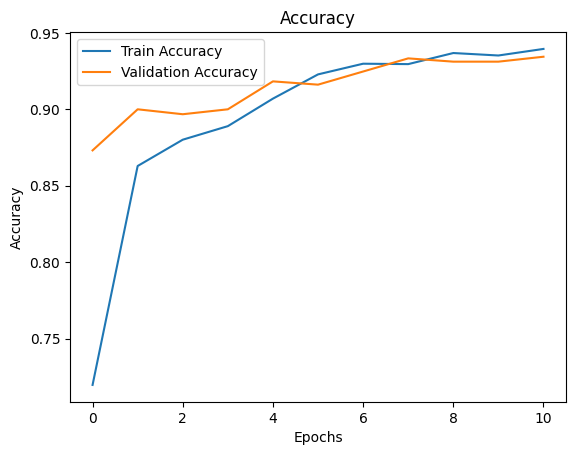

In [47]:
# Vẽ đồ thị biểu diễn độ chính xác của mô hình qua các epoch trong quá trình huấn luyện
plt.title("Accuracy")
plt.plot(result.history["accuracy"], label='Train Accuracy')
plt.plot(result.history["val_accuracy"], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

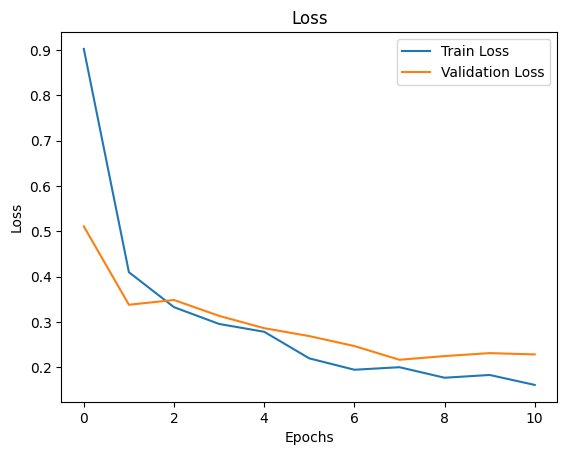

In [48]:
# Vẽ đồ thị biểu diễn hàm mất mát (loss) của mô hình qua các epoch trong quá trình huấn luyện.
plt.title("Loss")
plt.plot(result.history["loss"], label='Train Loss')
plt.plot(result.history["val_loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Mục mới